In [122]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


# активационная функция
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


# производная активационной функции
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))


# квадратичная целевая функция
# test_data - кортеж из входных значений и списка значений классов
def cost_function(network, test_data):
    c = 0
    for example, y in test_data:
        c += np.sum((network.feedforward(example) - y) ** 2)
    return c / (2 * len(test_data))


In [123]:
class Network:
    def __init__(self, shape, activation_function, activation_function_derivative, debug=True):
        self.shape = shape
        print(shape)
        self.biases = [np.random.randn(y, 1) for y in shape[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(shape[:-1], shape[1:])]
        for i in range(0, 3):
            self.weights[i] = (self.weights[i] - 0.5) * 2 * np.sqrt(1 / shape[i])
            self.biases[i] = (self.biases[i] - 0.5) * 2 * np.sqrt(1 / shape[i])
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.debug = debug

    # прогнать до конца примеры из input_matrix
    def feedforward(self, input_matrix):
        for b, w in zip(self.biases, self.weights):
            # weigts - (массив матриц)
            input_matrix = self.activation_function(np.dot(w, input_matrix) + b)
        return input_matrix

    # обновление параметров нейронной сети (веса, смещения), сделав шаг градиентного спуска
    # на основе алгоритма обратного распространения ошибки
    # alpha - learning rate
    def back_prop_step(self, data, alpha):
        # значения dJ/db для каждого слоя
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        # значения dJ/dw (ошибки) для каждого слоя
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # для каждого примера из батча применяем бек пропогейшн
        for x, y in data:
            delta_nabla_b, delta_nabla_w = self.back_prop_single_example(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        eps = alpha / len(data)

        # обновляем параметры сети
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - eps * nb for b, nb in zip(self.biases, nabla_b)]

    def prepare_data(data, classes_count):
        return [(row[:-classes_count].reshape(-1, 1), row[-classes_count:].reshape(-1, 1)) for row in data]

    def SGD(self, data_in, epochs, alpha, classes_count):
        errors = []

        for epoch in range(epochs):
            for row in data_in:
                input_data = row[:-classes_count].reshape(-1, 1)
                output_data = row[-classes_count:].reshape(-1, 1)
                self.back_prop_step([(input_data, output_data)], alpha)

            error = cost_function(self,
                                  [(row[:-classes_count].reshape(-1, 1), row[-classes_count:].reshape(-1, 1)) for row in
                                   data_in])
            if self.debug:
                print(f'epoch: {epoch} -  error:{error}')
                errors.append(error)
        return errors

    # возвращает вектор частных производных квадратичной целевой функции по активациям выходного слоя
    def cost_derivative(self, output_activations, y):
        return output_activations - y

    # алгоритм обратного распространения ошибки для одного примера из тренировочной выборки
    # возвращает кортеж (nabla_b, nabla_w) - градиентов по слоям по смещениям и весам соответственно
    def back_prop_single_example(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)
        # массив векторов активаций нейронов
        activations = [x]
        # массив векторов сумматорных функций от активаций предыдущих слоев

        summatories = []
        # b - вектор смещений нейронов данного слоя
        # w - матрица весов, входящих в данный слой
        for b, w in zip(self.biases, self.weights):
            summatories.append(np.dot(w, activations[-1]) + b)
            activation = self.activation_function(summatories[-1])
            activations.append(activation)

            # обратное распространение (backward pass)

            # ошибка для выходного слоя
        delta = self.cost_derivative(activations[-1], y) * self.activation_function_derivative(summatories[-1])
        # производная J по биасам выходного слоя
        nabla_b[-1] = delta
        # производная J по весам выходного слоя
        nabla_w[-1] = delta.dot(activations[-2].T)

        # Здесь l = 1 означает последний слой, l = 2 - предпоследний и так далее.
        for l in range(2, len(self.shape)):
            derivative = self.activation_function_derivative(summatories[-l])
            # ошибка на слое L-l
            delta = derivative * self.weights[-l + 1].T.dot(delta)
            # производная J по смещениям L-l-го слоя
            nabla_b[-l] = delta
            # производная J по весам L-l-го слоя
            nabla_w[-l] = delta.dot(activations[-l - 1].T)
        return nabla_b, nabla_w

In [124]:
def get_normalized_data(data, classes_count):
    normalized = (data / data.max())
    normalized.iloc[:, :-classes_count] = normalized.iloc[:, :-classes_count].fillna(0)
    mean = normalized.iloc[:, -classes_count:].mean()
    normalized.iloc[:, -classes_count:] = normalized.iloc[:, -classes_count:].fillna(mean)
    return normalized.to_numpy()

In [125]:
#data = pd.read_csv('clearedDataset.csv', delimiter=';',encoding='utf-8')
data = pd.read_csv('clearedDataset.csv', thousands='.', decimal=',', encoding='windows-1251')
train_data = data.sample(frac=0.7)
test_data = data.loc[~data.index.isin(train_data.index)]
normalized_train_data = get_normalized_data(train_data, 2)
normalized_test_data = get_normalized_data(test_data, 2)

In [126]:

mean = np.mean(normalized_test_data)
print(mean)


0.4528045192330293


In [127]:
data


,Руст,Рзаб,Pлин,Руст.1,Рзаб.1,Рлин,Тзаб,Tлин,Дебит газа,Дебит ст. конд.,Дебит воды,Дебит смеси,Дебит гааз,Дебит кон нестабильный,Pсб,Pсб.1,G_total,КГФ
0,2496,3701,1018,2490,3596,1018,1032,325,2147,836,4,23125,161037,1313,936,9238,2780.0,311910.0
1,2335,3646,1013,2310,3381,1024,1030,386,29059,1047,14,3090,231023,1585,929,9169,370.0,28860.0
2,2134,3571,1016,2110,3148,1006,1026,434,36804,1143,19,38811,303949,1723,914,902,4520.0,248790.0
3,1916,3474,984,1870,2915,990,1020,461,43466,1213,33,45521,382408,1815,892,8803,5220.0,223560.0
4,1719,3377,992,1690,2703,995,1044,499,48328,1298,46,50459,42991,1906,897,8853,5770.0,215150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1822,27159,9326,1790,2586,927,10491,4183,3946,851,15,40897,37280,1283,897,8853,NaN,NaN
155,1570,24908,9647,1530,2335,10006,1045,4772,4556,894,17,47101,43020,1359,873,8616,NaN,NaN
156,2119,28939,9113,2080,2896,913,1049,2484,18843,6147,112,20087,15500,924,882,8705,NaN,NaN
157,2040,28287,9117,2010,2753,9162,10488,3158,26104,7291,475,27371,22650,1089,885,8734,NaN,NaN


In [128]:
network = Network([16, 60, 70, 2], sigmoid, sigmoid_prime, True)
errors = network.SGD(normalized_train_data, epochs=350, alpha=0.01, classes_count=2)

[16, 60, 70, 2]
epoch: 0 -  error:0.13005836461003498
epoch: 1 -  error:0.10236782154452481
epoch: 2 -  error:0.0755770022060158
epoch: 3 -  error:0.05569811778209336
epoch: 4 -  error:0.04386313014108766
epoch: 5 -  error:0.03756906455629944
epoch: 6 -  error:0.034285708699246846
epoch: 7 -  error:0.03250492409891501
epoch: 8 -  error:0.03146466895391718
epoch: 9 -  error:0.030796242398532972
epoch: 10 -  error:0.030321089939644254
epoch: 11 -  error:0.02995148903836787
epoch: 12 -  error:0.029643664849084417
epoch: 13 -  error:0.029375495704839546
epoch: 14 -  error:0.02913569021546912
epoch: 15 -  error:0.02891841135480853
epoch: 16 -  error:0.02872055152639881
epoch: 17 -  error:0.028540331347107706
epoch: 18 -  error:0.02837657571538178
epoch: 19 -  error:0.028228344155602037
epoch: 20 -  error:0.028094749923924925
epoch: 21 -  error:0.027974880858200914
epoch: 22 -  error:0.027867774962661327
epoch: 23 -  error:0.02777242460113016
epoch: 24 -  error:0.027687794392600173
epoch: 25

In [129]:
def rmse(network, train_data):
    return np.sqrt(cost_function(network, train_data))


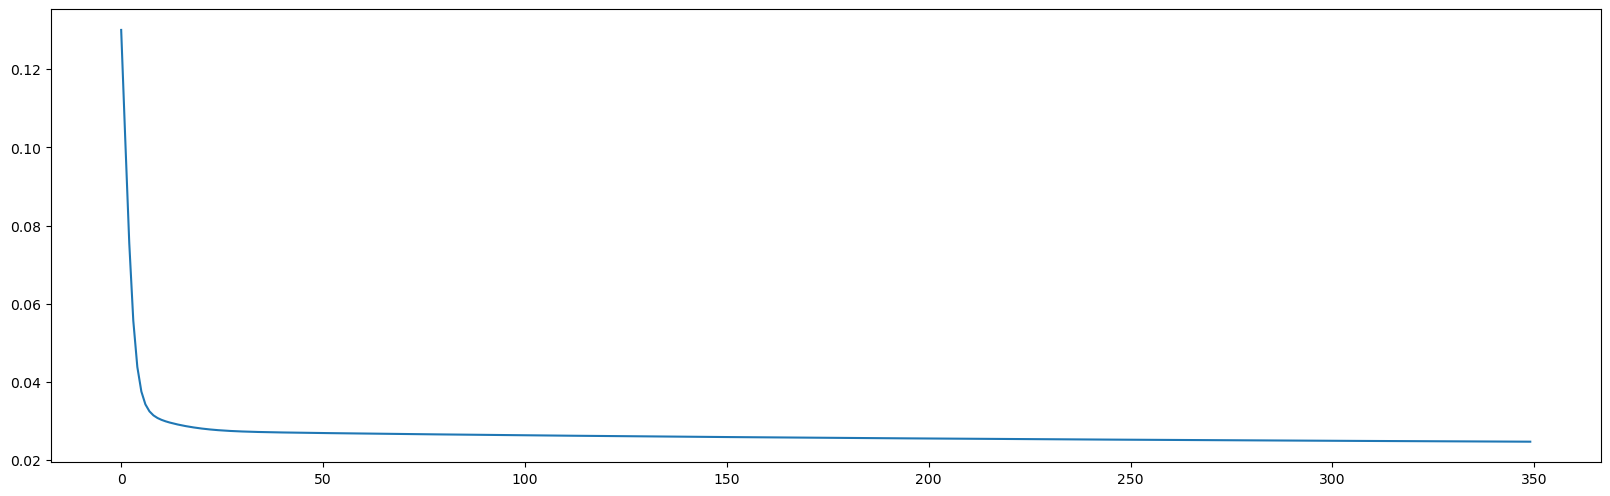

0.25609464644328245


In [130]:
fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.subplot(3, 1, 1)
plt.plot(errors)

plt.show()
print(rmse(network, Network.prepare_data(normalized_test_data, 2)))

[13, 20, 35, 2]
epoch: 0 -  error:0.10811972810078463
epoch: 1 -  error:0.07633293368703092
epoch: 2 -  error:0.06819245835223382
epoch: 3 -  error:0.06469316492811882
epoch: 4 -  error:0.06261780431818632
epoch: 5 -  error:0.06105918447182144
epoch: 6 -  error:0.05977992934267789
epoch: 7 -  error:0.05872241501228756
epoch: 8 -  error:0.05785237045922944
epoch: 9 -  error:0.05712753557706437
epoch: 10 -  error:0.05650528261931122
epoch: 11 -  error:0.05594870077762959
epoch: 12 -  error:0.05542596541117744
epoch: 13 -  error:0.05490613815626749
epoch: 14 -  error:0.05435236208758033
epoch: 15 -  error:0.053712096552078904
epoch: 16 -  error:0.05291022267449117
epoch: 17 -  error:0.05188863927774562
epoch: 18 -  error:0.05075213215269931
epoch: 19 -  error:0.04972803284739779
epoch: 20 -  error:0.048863197271076075
epoch: 21 -  error:0.04809821797691496
epoch: 22 -  error:0.047395391431620124
epoch: 23 -  error:0.046735041420588194
epoch: 24 -  error:0.046097805969585154
epoch: 25 -  e

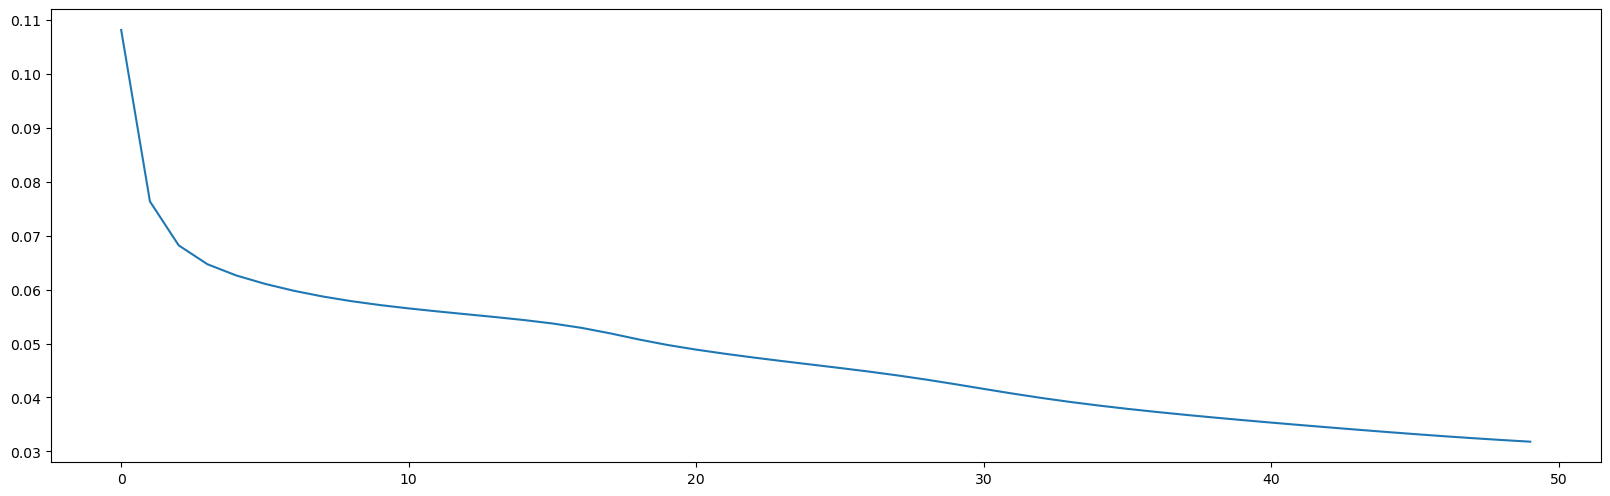

0.17939976861510207


In [131]:
data3 = pd.read_csv('final-mushroom-dataset.csv', thousands='.', decimal=',', encoding='windows-1251')
train_data3 = data3.sample(frac=0.7)
test_data3 = data3.loc[~data3.index.isin(train_data3.index)]
normalized_train_data3 = get_normalized_data(train_data3, 2)
normalized_test_data3 = get_normalized_data(test_data3, 2)
#network = Network([16, 60, 70, 2], sigmoid, sigmoid_prime, True)
network = Network([13, 20, 35, 2], sigmoid, sigmoid_prime, True)
errors3 = network.SGD(normalized_train_data3, epochs=50, alpha=0.03, classes_count=2)
#errors3 = network.SGD(normalized_train_data3, epochs=10, alpha=0.005, classes_count=2)
fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.subplot(3, 1, 1)
plt.plot(errors3)

plt.show()
print(rmse(network, Network.prepare_data(normalized_test_data3, 2)))

Метрики для скважин

0.8301568899956778
0.8142857142857143


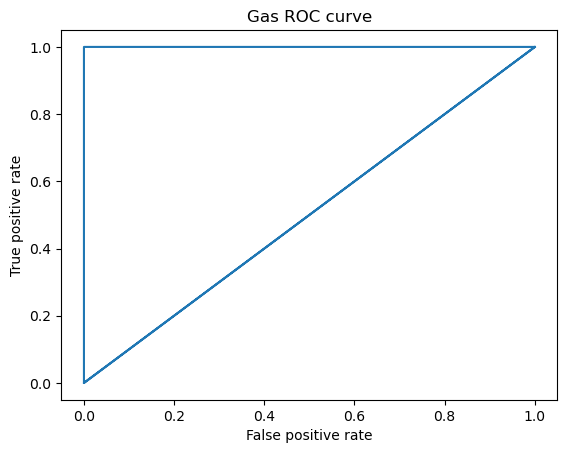

<Figure size 640x480 with 0 Axes>

In [136]:
from sklearn.metrics import r2_score
def calc_r_square(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    sse = np.sum((y_true - y_pred) ** 2)
    ssr = np.sum((y_pred - np.mean(y_true)) ** 2)
    return 1 - (sse / ssr)

def calc_f_measure(y_true, y_pred, threshold=0.5):
    y_pred = np.where(y_pred > threshold, 1, 0)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    if (tp + fp) == 0 or (tp + fn) == 0:
        return 0
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)
def calc_roc(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    thresholds = np.sort(np.unique(y_pred))[::-1]
    fpr = np.zeros(len(thresholds) + 2)
    tpr = np.zeros(len(thresholds) + 2)
    fpr[-1] = 1
    tpr[-1] = 1
    for i, threshold in enumerate(thresholds):
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        tp = np.sum((y_true == 1) & (y_pred_binary == 1))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        tn = np.sum((y_true == 0) & (y_pred_binary == 0))
        fn = np.sum((y_true == 1) & (y_pred_binary == 0))
        if (tp + fp) == 0 or (tp + fn) == 0:
            fpr[i] = 0
            tpr[i] = 0
        else:
            fpr[i] = fp / (fp + tn)
            tpr[i] = tp / (tp + fn)
    return fpr, tpr

random_indices = np.random.choice(len(normalized_train_data), size=len(normalized_test_data), replace=False)
subset_normalized_train_data = normalized_train_data[random_indices]
print(calc_r_square(subset_normalized_train_data,normalized_test_data))

print(calc_f_measure(subset_normalized_train_data, normalized_test_data))

gas_total_fpr, gas_total_tpr = calc_roc(subset_normalized_train_data, normalized_test_data)

plt.plot(gas_total_fpr, gas_total_tpr)
plt.title('Gas ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
plt.clf()

Метрики для грибов

0.8244177416445181
0.8145168407118695


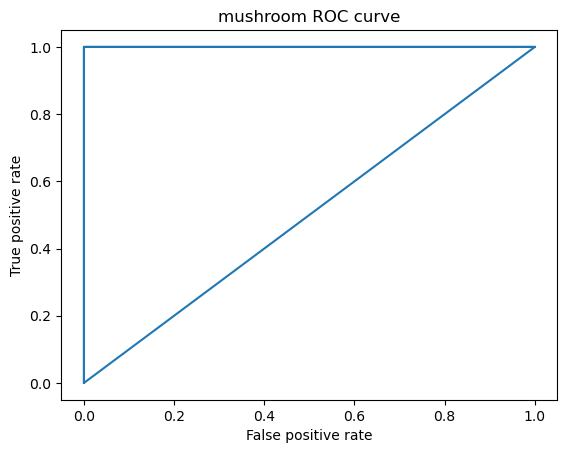

<Figure size 640x480 with 0 Axes>

In [137]:
def calc_r_square(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    sse = np.sum((y_true - y_pred) ** 2)
    ssr = np.sum((y_pred - np.mean(y_true)) ** 2)
    return 1 - (sse / ssr)

def calc_f_measure(y_true, y_pred, threshold=0.5):
    y_pred = np.where(y_pred > threshold, 1, 0)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    if (tp + fp) == 0 or (tp + fn) == 0:
        return 0
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def calc_roc(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    thresholds = np.sort(np.unique(y_pred))[::-1]
    fpr = np.zeros(len(thresholds) + 2)
    tpr = np.zeros(len(thresholds) + 2)
    fpr[-1] = 1
    tpr[-1] = 1
    for i, threshold in enumerate(thresholds):
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        tp = np.sum((y_true == 1) & (y_pred_binary == 1))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        tn = np.sum((y_true == 0) & (y_pred_binary == 0))
        fn = np.sum((y_true == 1) & (y_pred_binary == 0))
        if (tp + fp) == 0 or (tp + fn) == 0:
            fpr[i] = 0
            tpr[i] = 0
        else:
            fpr[i] = fp / (fp + tn)
            tpr[i] = tp / (tp + fn)
    return fpr, tpr

random_indices = np.random.choice(len(normalized_train_data3), size=len(normalized_test_data3), replace=False)
subset_normalized_train_data3 = normalized_train_data3[random_indices]
print(calc_r_square(subset_normalized_train_data3,normalized_test_data3))

print(calc_f_measure(subset_normalized_train_data3, normalized_test_data3))

mushroom_fpr, mushroom_tpr = calc_roc(subset_normalized_train_data3, normalized_test_data3)

plt.plot(mushroom_fpr, mushroom_tpr)
plt.title('mushroom ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
plt.clf()

